In [18]:
# !pip install PyPortfolioOpt

In [19]:
# 필요한 라이브러리들을 불러옵니다.
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 포트폴리오 최적화를 위한 PyPortfolioOpt 라이브러리
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

# 데이터프레임 출력 옵션 설정
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# --- 설정값 ---
INPUT_FILENAME = "top_50_zscore_rank_3Y.csv"
# ---

try:
    top_50_df = pd.read_csv(INPUT_FILENAME)
    tickers = top_50_df['Ticker'].tolist()
    tickers = list(set(tickers))

    print(f"✅ '{INPUT_FILENAME}'에서 상위 {len(tickers)}개 티커를 불러왔습니다.")
    print(tickers)
except FileNotFoundError:
    print(f"❌ 오류: '{INPUT_FILENAME}' 파일을 찾을 수 없습니다. 이전 단계를 먼저 실행해주세요.")
    tickers = []



✅ 'top_50_zscore_rank_3Y.csv'에서 상위 50개 티커를 불러왔습니다.
['ASM', 'IESC', 'IREN', 'RKLB', 'LMB', 'VRT', 'MFH', 'INOD', 'ABBV', 'STKE', 'CRDO', 'ROOT', 'HRTG', 'APP', 'CIFR', 'VKTX', 'AAOI', 'TSSI', 'IONQ', 'MAMA', 'APLD', 'PSIX', 'UAMY', 'QURE', 'MOD', 'CVNA', 'SKYX', 'FTAI', 'QUBT', 'CLS', 'STRL', 'AMSC', 'ACIC', 'WULF', 'TPC', 'PPTA', 'SLNO', 'HOOD', 'HCA', 'DAVE', 'RGTI', 'POWL', 'HIMS', 'MSTR', 'IAG', 'VRNA', 'OKLO', 'RYTM', 'PLTR', 'SMMT']


In [20]:
# if tickers:
#     # 데이터 수집 기간 설정 (오늘부터 3년 전까지)
#     end_date = datetime.today()
#     start_date = end_date - timedelta(days=3*365)
    
#     print(f"\n✅ 데이터 수집 기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
    
#     # yfinance를 통해 50개 종목의 수정 종가 데이터를 다운로드합니다.
#     prices = yf.download(tickers, start=start_date, end=end_date)['Adj Close'].dropna(how="all")
#     print("\n✅ 주가 데이터 수집 완료!")
#     display(prices.head())

In [21]:
if tickers:
    # 데이터 수집 기간 설정
    end_date = datetime.today()
    start_date = end_date - timedelta(days=3*365)
    
    print(f"\n✅ 데이터 수집 기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
    
    # yfinance를 통해 전체 데이터를 다운로드합니다.
    # 최신 버전에서는 auto_adjust=True가 기본값이므로 'Adj Close'가 아닌 'Close'를 사용합니다.
    data = yf.download(tickers, start=start_date, end=end_date)
    
    # 'Close' 컬럼만 선택합니다. (이것이 이제 수정 종가입니다)
    if isinstance(data.columns, pd.MultiIndex):
        prices = data['Close'] # 이 부분을 수정
    else:
        prices = data[['Close']] # 이 부분도 수정

    prices = prices.dropna(how="all")
    
    print("\n✅ 주가 데이터 수집 완료!")
    display(prices.head())




✅ 데이터 수집 기간: 2022-09-27 ~ 2025-09-26


/tmp/ipykernel_3772804/3381222765.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  50 of 50 completed


✅ 주가 데이터 수집 완료!


Ticker,AAOI,ABBV,ACIC,AMSC,APLD,APP,ASM,CIFR,CLS,CRDO,CVNA,DAVE,FTAI,HCA,HIMS,HOOD,HRTG,IAG,IESC,INOD,IONQ,IREN,LMB,MAMA,MFH,MOD,MSTR,OKLO,PLTR,POWL,PPTA,PSIX,QUBT,QURE,RGTI,RKLB,ROOT,RYTM,SKYX,SLNO,SMMT,STKE,STRL,TPC,TSSI,UAMY,VKTX,VRNA,VRT,WULF
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-09-27,2.83,126.600693,0.645111,4.55,1.73,20.379999,0.50,1.31,8.36,11.58,24.830000,13.920,13.939439,179.725082,5.38,9.61,2.08,0.98,26.620001,2.91,4.84,3.68,7.05,1.09,0.933333,13.48,20.607000,9.72,7.63,19.744656,1.93,1.7,2.33,18.040001,1.82,4.19,8.32,22.610001,3.71,1.71,1.21,0.384,20.830000,5.72,0.59,0.36,2.60,9.14,9.645545,1.12
2022-09-28,2.95,129.173462,0.635483,4.58,1.74,21.370001,0.51,1.34,8.66,12.03,26.870001,12.896,14.800812,185.215027,5.70,10.01,2.39,1.07,28.139999,2.90,5.07,3.77,7.21,1.09,0.931111,13.70,22.047001,9.75,7.94,20.573376,2.00,1.7,2.31,18.860001,1.87,4.38,8.66,24.760000,3.73,1.72,1.21,0.384,21.469999,5.87,0.61,0.38,2.71,9.55,10.303196,1.35
2022-09-29,2.66,127.493996,0.587340,4.45,1.60,19.680000,0.50,1.22,8.47,11.69,21.570000,11.520,13.920914,183.011246,5.59,9.77,2.40,1.05,27.490000,2.88,4.78,3.78,7.05,1.11,1.011111,13.05,21.181999,9.70,8.08,20.139746,1.98,1.7,2.37,17.920000,1.73,4.16,7.99,23.870001,3.75,1.63,1.15,0.384,21.250000,5.64,0.60,0.38,2.75,9.43,9.655508,1.31
2022-09-30,2.72,119.891930,0.616226,4.38,1.70,19.490000,0.51,1.26,8.41,11.00,20.299999,11.488,13.888497,179.218002,5.58,10.10,2.26,1.07,27.620001,3.02,5.07,4.13,7.60,1.09,0.944444,12.94,21.226000,9.76,8.13,20.313196,2.02,1.7,2.51,18.760000,1.88,4.07,7.88,24.500000,3.69,1.67,1.19,0.400,21.469999,5.52,0.60,0.37,2.72,10.22,9.685403,1.26
2022-10-03,2.75,123.563446,0.664369,4.59,1.73,20.420000,0.55,1.17,8.70,11.31,21.459999,13.056,14.522949,188.452408,5.56,10.10,2.29,1.19,28.719999,3.26,5.26,4.05,7.91,1.10,0.944444,13.44,22.452000,9.74,8.24,20.611919,2.05,1.7,2.46,19.530001,1.93,4.31,8.39,23.709999,3.68,1.74,1.21,0.400,22.680000,5.72,0.60,0.38,2.72,10.11,11.209957,1.42


In [28]:
if not prices.empty:
    # 1. 연간 기대수익률 계산 (과거 데이터 기반)
    mu = expected_returns.mean_historical_return(prices)
    # mu = expected_returns.ema_historical_return(prices)
    
    # 2. 연간 공분산 행렬 계산 (위험 모델)
    S = risk_models.sample_cov(prices)
    
    print("✅ 연간 기대수익률 (mu):")
    display(mu.head())
    print("\n✅ 연간 공분산 행렬 (S):")
    display(S.head())

✅ 연간 기대수익률 (mu):


Ticker
AAOI    1.113943
ABBV    0.201041
ACIC    1.615161
AMSC    1.348685
APLD    1.368280
dtype: float64


✅ 연간 공분산 행렬 (S):


Ticker,AAOI,ABBV,ACIC,AMSC,APLD,APP,ASM,CIFR,CLS,CRDO,CVNA,DAVE,FTAI,HCA,HIMS,HOOD,HRTG,IAG,IESC,INOD,IONQ,IREN,LMB,MAMA,MFH,MOD,MSTR,OKLO,PLTR,POWL,PPTA,PSIX,QUBT,QURE,RGTI,RKLB,ROOT,RYTM,SKYX,SLNO,SMMT,STKE,STRL,TPC,TSSI,UAMY,VKTX,VRNA,VRT,WULF
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAOI,1.506496,0.004196,0.057533,0.379685,0.355065,0.323509,0.097868,0.438608,0.255922,0.326468,0.354809,0.259138,0.160608,0.021634,0.220198,0.266522,0.075811,0.095565,0.236029,0.430572,0.385280,0.387653,0.167776,0.047794,0.048812,0.233911,0.272335,0.188152,0.256821,0.162136,0.070745,0.178472,0.383862,0.117669,0.424692,0.228912,0.104497,0.134187,0.170408,0.112974,0.085742,0.302188,0.170434,0.130590,0.239754,0.150195,0.198799,0.117954,0.282332,0.418191
ABBV,0.004196,0.053360,0.000856,0.006124,-0.010635,0.007098,0.018517,0.009518,0.002070,0.000670,-0.007133,0.011874,0.010994,0.012967,0.007694,0.007291,0.013548,0.010530,0.003637,-0.006310,0.005575,-0.015915,0.002170,0.005034,-0.020698,0.000579,-0.010853,0.001843,0.008483,-0.000093,0.005653,0.001115,0.014891,0.009231,0.006331,0.007614,0.013362,0.020781,0.007577,0.006852,0.027207,-0.010068,-0.000672,0.002106,0.017195,0.008497,0.033397,0.011770,-0.000020,0.008411
ACIC,0.057533,0.000856,1.132938,0.100674,0.193630,0.040965,0.000024,0.121962,0.030845,-0.009961,0.074658,0.076293,0.029307,0.020647,0.013801,0.044309,0.186204,0.049957,0.057795,0.097120,0.093232,0.062420,0.057445,0.096417,0.011285,0.014453,0.054753,-0.031291,0.056328,0.055797,0.057249,0.075385,0.046857,0.057310,0.066622,0.053005,0.029438,0.064890,0.088529,-0.078545,0.008921,-0.056524,0.040118,0.018757,0.066707,0.021149,0.064867,0.061661,0.015903,-0.001089
AMSC,0.379685,0.006124,0.100674,0.859480,0.307853,0.187697,0.072216,0.272649,0.152090,0.201465,0.328827,0.192603,0.118691,0.025528,0.185384,0.184359,0.096401,0.082193,0.178596,0.333368,0.282768,0.293669,0.158711,0.050077,0.088538,0.176678,0.242827,0.162846,0.186378,0.104231,0.106716,0.091506,0.209008,0.098243,0.351646,0.225589,0.178772,0.181517,0.164695,0.030805,0.186245,0.103516,0.154118,0.168249,0.186778,0.097391,0.108181,0.112177,0.158507,0.284909
APLD,0.355065,-0.010635,0.193630,0.307853,1.674691,0.211208,0.129203,0.561383,0.161475,0.210535,0.323052,0.181289,0.097690,0.008877,0.175894,0.251038,0.057009,0.105069,0.152094,0.290766,0.386935,0.489619,0.166981,0.086644,0.165831,0.194136,0.319591,0.235538,0.218653,0.160452,0.185506,0.129846,0.298214,-0.003416,0.390952,0.232866,0.166362,0.103605,0.127902,0.123175,0.045552,-0.013693,0.157852,0.153478,0.324861,0.174430,0.148894,0.089293,0.193396,0.608848


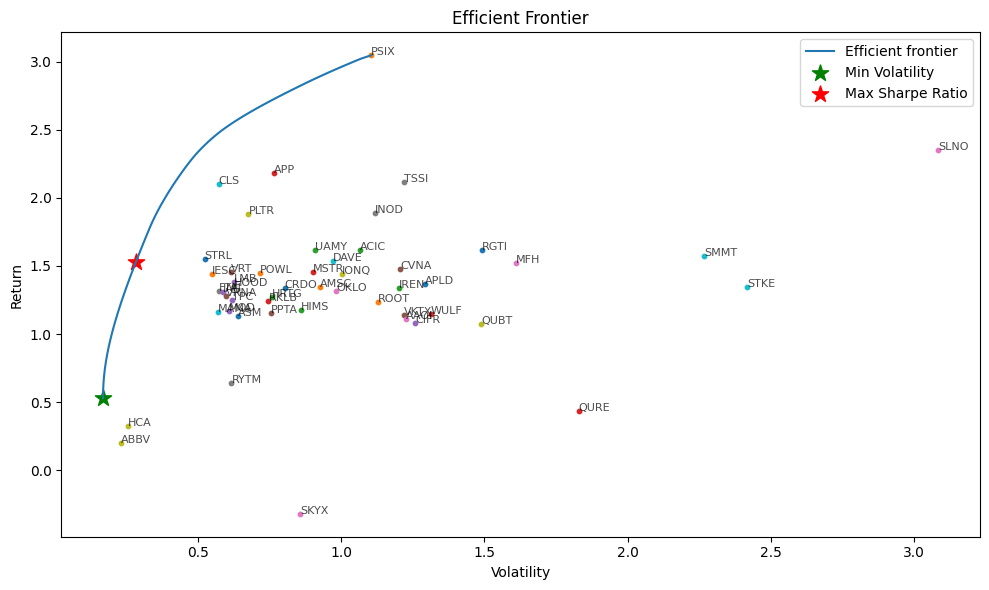


--- 최소 변동성 포트폴리오 ---
기대수익률: 53.08%, 변동성(리스크): 16.89%

--- 최대 샤프 지수 포트폴리오 ---
기대수익률: 153.15%, 변동성(리스크): 28.40%


In [29]:

# 'mu'와 'S'는 이미 계산되었다고 가정합니다.
if 'mu' in locals() and 'S' in locals():
    
    # 1. 최소 변동성 포트폴리오 계산
    # 객체를 새로 생성합니다.
    ef_min_vol = EfficientFrontier(mu, S)
    min_vol_weights = ef_min_vol.min_volatility()
    min_vol_ret, min_vol_risk, _ = ef_min_vol.portfolio_performance()
    
    # 2. 최대 샤프 지수 포트폴리오 계산
    # 객체를 다시 새로 생성합니다.
    ef_max_sharpe = EfficientFrontier(mu, S)
    max_sharpe_weights = ef_max_sharpe.max_sharpe()
    max_sharpe_ret, max_sharpe_risk, _ = ef_max_sharpe.portfolio_performance()

    # 3. 시각화 (효율적 투자선은 한 번만 계산)
    ef_for_plotting = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(10, 6))
    plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=False)
    
    # 계산된 포트폴리오 결과 플로팅
    ax.scatter(min_vol_risk, min_vol_ret, marker="*", color="g", s=150, label="Min Volatility")
    ax.scatter(max_sharpe_risk, max_sharpe_ret, marker="*", color="r", s=150, label="Max Sharpe Ratio")

    # # 각 포트폴리오의 티커별 위치 표시
    for ticker in tickers:
        ret = mu[ticker]
        risk = np.sqrt(S.loc[ticker, ticker])
        ax.scatter(risk, ret, marker="o", s=10)
        ax.text(risk, ret, ticker, fontsize=8, alpha=0.7)
    

    # 그래프 스타일 설정
    ax.set_title("Efficient Frontier")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print("\n--- 최소 변동성 포트폴리오 ---")
    print(f"기대수익률: {min_vol_ret:.2%}, 변동성(리스크): {min_vol_risk:.2%}")
    
    print("\n--- 최대 샤프 지수 포트폴리오 ---")
    print(f"기대수익률: {max_sharpe_ret:.2%}, 변동성(리스크): {max_sharpe_risk:.2%}")

In [32]:
def print_weights(weights):
    """가중치를 깔끔하게 출력하는 함수"""
    weights_series = pd.Series(weights)
    # 가중치가 0.1% 이상인 종목만 출력
    print(weights_series[weights_series > 0.001].sort_values(ascending=False).to_string())

if 'ef' in locals():
    # 리스크 범위를 정의합니다 (최소 변동성 ~ 최대 샤프 지수)
    min_risk_level = min_vol_risk
    max_risk_level = max_sharpe_risk
    risk_range = max_risk_level - min_risk_level
    
    # 목표 리스크 수준을 퍼센트로 정의
    target_risk_percentages = [0.60, 0.65, 0.70, 0.80, 0.90, 1.00]
    
    print("\n" + "="*50)
    print("           특정 리스크 수준별 포트폴리오 가중치")
    print("="*50 + "\n")
    
    for p in target_risk_percentages:
        # 목표 변동성(리스크) 값을 계산
        target_risk = min_risk_level + risk_range * p
        
        print(f"--- 리스크 수준: {p:.0%} (목표 변동성: {target_risk:.2%}) ---")
        
        try:
            # 해당 목표 리스크를 달성하는 포트폴리오를 계산
            ef_target_risk = EfficientFrontier(mu, S)

            target_weights = ef_target_risk.efficient_risk(target_volatility=target_risk)
            
            # 가중치 출력
            print_weights(target_weights)
            print("\n" + "-"*50 + "\n")
            
        except Exception as e:
            print(f"해당 리스크 수준의 포트폴리오를 계산할 수 없습니다: {e}\n")

In [31]:
import json # JSON 라이브러리 추가

def print_weights(weights):
    """가중치를 깔끔하게 출력하는 함수"""
    weights_series = pd.Series(weights)
    # 가중치가 0.1% 이상인 종목만 출력
    print(weights_series[weights_series > 0.001].sort_values(ascending=False).to_string())

if 'ef' in locals():
    # 리스크 범위를 정의합니다 (최소 변동성 ~ 최대 샤프 지수)
    min_risk_level = min_vol_risk
    max_risk_level = max_sharpe_risk
    risk_range = max_risk_level - min_risk_level
    
    # 목표 리스크 수준을 퍼센트로 정의
    target_risk_percentages = [0.60, 0.65, 0.70, 0.80, 0.90, 1.00]
    
    print("\n" + "="*50)
    print("           특정 리스크 수준별 포트폴리오 가중치")
    print("="*50 + "\n")
    
    for p in target_risk_percentages:
        # 목표 변동성(리스크) 값을 계산
        target_risk = min_risk_level + risk_range * p
        
        print(f"--- 리스크 수준: {p:.0%} (목표 변동성: {target_risk:.2%}) ---")
        
        try:
            # 해당 목표 리스크를 달성하는 포트폴리오를 계산
            ef_target_risk = EfficientFrontier(mu, S)

            target_weights = ef_target_risk.efficient_risk(target_volatility=target_risk)
            
            # 가중치 출력
            print_weights(target_weights)

            # 📌 추가된 부분: p가 0.65일 때 JSON 파일로 저장
            if p == 0.65:
                # 가중치가 0.1% 이상인 종목만 필터링하여 새로운 딕셔너리 생성
                weights_to_save = {ticker: weight for ticker, weight in target_weights.items() if weight > 0.001}
                
                output_json_filename = 'portfolio_weights_65_risk.json'
                with open(output_json_filename, 'w', encoding='utf-8') as f:
                    json.dump(weights_to_save, f, ensure_ascii=False, indent=4)
                
                print(f"\n  ✨ 65% 리스크 포트폴리오가 '{output_json_filename}' 파일로 저장되었습니다.")

            print("\n" + "-"*50 + "\n")
            
        except Exception as e:
            print(f"해당 리스크 수준의 포트폴리오를 계산할 수 없습니다: {e}\n")

In [33]:

# 맥스 샤프 비율 포트폴리오 가중치를 JSON 파일로 저장
if 'max_sharpe_weights' in locals():
    # 가중치가 0.1% 이상인 종목만 필터링
    filtered_weights = {ticker: weight for ticker, weight in max_sharpe_weights.items() if weight > 0.001}
    
    # JSON 파일로 저장
    output_json_filename = 'portfolio_weights_max_sharpe.json'
    with open(output_json_filename, 'w', encoding='utf-8') as f:
        json.dump(filtered_weights, f, ensure_ascii=False, indent=4)
    
    print(f"\n✅ 맥스 샤프 비율 포트폴리오 가중치가 '{output_json_filename}' 파일로 저장되었습니다.")
    print(f"   - 종목 수: {len(filtered_weights)}")
    print(f"   - 가중치 합계: {sum(filtered_weights.values()):.4f}")


✅ 맥스 샤프 비율 포트폴리오 가중치가 'portfolio_weights_max_sharpe.json' 파일로 저장되었습니다.
   - 종목 수: 21
   - 가중치 합계: 1.0000


In [ ]:
input_filename = 'portfolio_weights_max_sharpe.json'
try:
    with open(input_filename, 'r', encoding='utf-8') as f:
        weights = json.load(f)
    
    # 현재 가중치 합계 계산
    current_sum = sum(weights.values())
    
    # 기존 가중치를 조정하여 총합이 0.6이 되도록 스케일링
    M_V = 0.4
    # 모든 가중치를 소수점 자리까지 반올림
    rounded_weights = {ticker: round(weight, 3) for ticker, weight in scaled_weights.items()}
    scaling_factor = 1-M_V / current_sum
    scaled_weights = {ticker: weight * scaling_factor for ticker, weight in weights.items()}
    
    # MONEY 티커 추가 (비중 0.4)
    scaled_weights['MONEY'] = M_V
    
    # 라운딩으로 인한 오차를 보정하여 정확히 합계가 1이 되도록 조정
    total_after_rounding = sum(rounded_weights.values())
    if total_after_rounding != 1.00:
        # 가장 큰 가중치를 가진 티커에 오차를 더하거나 빼서 합계를 1로 맞춤
        max_ticker = max(rounded_weights.items(), key=lambda x: x[1] if x[0] != 'MONEY' else 0)[0]
        rounded_weights[max_ticker] = round(rounded_weights[max_ticker] + (1.00 - total_after_rounding), 3)
    
    # 최종 포트폴리오 가중치를 JSON 파일로 저장
    output_filename = 'final_portfolio_weights.json'
    with open(output_filename, 'w', encoding='utf-8') as f:
        json.dump(rounded_weights, f, ensure_ascii=False, indent=4)
    
    print(f"\n✅ 최종 포트폴리오 가중치가 '{output_filename}' 파일로 저장되었습니다.")
    print(f"   - MONEY 비중: {rounded_weights.get('MONEY', 0):.3f}")
    print(f"   - 기타 자산 비중 총합: {sum(rounded_weights.values()) - rounded_weights.get('MONEY', 0):.3f}")
    print(f"   - 전체 비중 총합: {sum(rounded_weights.values()):.3f}")
    
except FileNotFoundError:
    print(f"❌ 오류: '{input_filename}' 파일을 찾을 수 없습니다. 이전 단계를 먼저 실행해주세요.")
except Exception as e:
    print(f"❌ 오류 발생: {str(e)}")


✅ 최종 포트폴리오 가중치가 'final_portfolio_weights.json' 파일로 저장되었습니다.
   - MONEY 비중: 0.400
   - 기타 자산 비중 총합: 0.600
   - 전체 비중 총합: 1.000
